<a href="https://colab.research.google.com/github/josefstrnad/03_Stock_price_prediction_LSTM_/blob/main/Stock_price_prediction_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock market prediction with LSTM

In [ ]:
# predicting 

In [29]:
!pip install yahoo-fin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD

import yahoo_fin.stock_info as yh

# Loading data

In [31]:
response = yh.get_data('AAPL', start_date = '01/03/2013', end_date = '01/31/2023', index_as_date = False, interval = '1d')

In [32]:
response.head()

,date,open,high,low,close,adjclose,volume,ticker
0,2013-01-03,19.567142,19.631071,19.321428,19.360714,16.624599,352965200,AAPL
1,2013-01-04,19.177500,19.236786,18.779642,18.821428,16.161520,594333600,AAPL
2,2013-01-07,18.642857,18.903570,18.400000,18.710714,16.066454,484156400,AAPL
3,2013-01-08,18.900356,18.996071,18.616072,18.761070,16.109694,458707200,AAPL
4,2013-01-09,18.660713,18.750357,18.428213,18.467857,15.857922,407604400,AAPL


In [33]:
response.shape

(2536, 8)

In [34]:
df = pd.DataFrame(response)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2536 entries, 0 to 2535
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      2536 non-null   datetime64[ns]
 1   open      2536 non-null   float64       
 2   high      2536 non-null   float64       
 3   low       2536 non-null   float64       
 4   close     2536 non-null   float64       
 5   adjclose  2536 non-null   float64       
 6   volume    2536 non-null   int64         
 7   ticker    2536 non-null   object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 158.6+ KB


In [36]:
#Convert date
def to_datetime(df):
    date = datetime.strptime(df, '%d.%m.%Y')
    return date.strftime("%Y-%m-%d")

In [37]:
df = df.sort_values('date').reset_index(drop=True)

In [38]:
df = df.rename(columns={'date': 'Date', 'close': 'Price'})
df = df[['Date', 'Price']]
df

,Date,Price
0,2013-01-03,19.360714
1,2013-01-04,18.821428
2,2013-01-07,18.710714
3,2013-01-08,18.761070
4,2013-01-09,18.467857
...,...,...
2531,2023-01-24,142.529999
2532,2023-01-25,141.860001
2533,2023-01-26,143.960007
2534,2023-01-27,145.929993


In [39]:
df.head()

,Date,Price
0,2013-01-03,19.360714
1,2013-01-04,18.821428
2,2013-01-07,18.710714
3,2013-01-08,18.761070
4,2013-01-09,18.467857


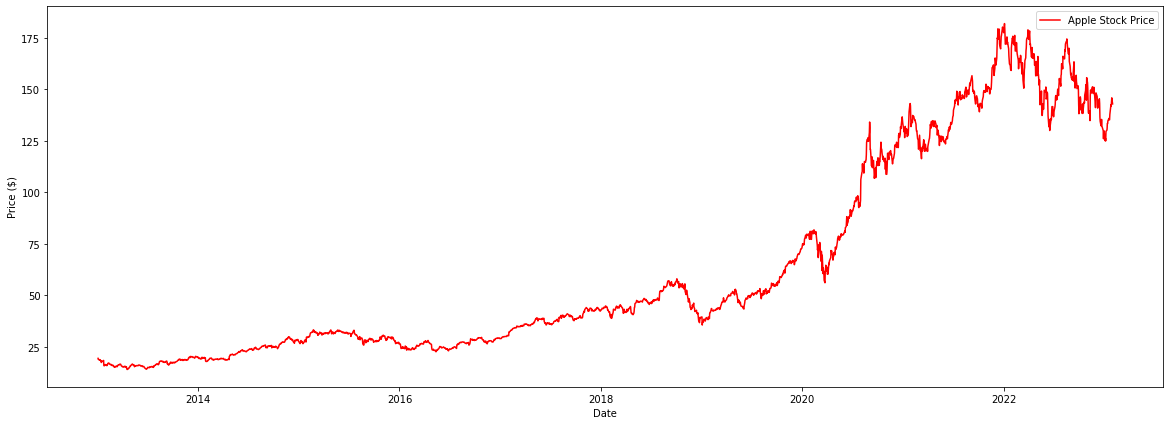

In [40]:
df['Price'] = df['Price'].astype(float)

plt.figure(figsize=(20,7))
plt.plot(df['Date'].values, df['Price'].values, label = 'Apple Stock Price', color = 'red')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

# Data preprocessing

In [41]:
num_rows = 2500

train = df.iloc[:num_rows, 1:2].values
test = df.iloc[num_rows:, 1:2].values

In [42]:
sc = MinMaxScaler(feature_range = (0, 1))
train_scaled = sc.fit_transform(train)

In [43]:
train.shape

(2500, 1)

In [44]:
test.shape

(36, 1)

In [45]:
X_train = []

#Price on next day
y_train = []

lookback = 60  # prepsat na lookback

for i in range(lookback, num_rows):
    X_train_ = np.reshape(train_scaled[i-lookback:i, 0], (lookback, 1))
    X_train.append(X_train_)
    y_train.append(train_scaled[i, 0])
X_train = np.stack(X_train)
y_train = np.stack(y_train)

# MODEL

In [46]:
# Initializing the Recurrent Neural Network
model = Sequential()
#Adding the first LSTM layer with a sigmoid activation function and some Dropout regularization
#Units - dimensionality of the output space

model.add(LSTM(units = 50, return_sequences = True, input_shape = (60, 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_5 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_6 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_6 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 50)               

In [47]:
early_stop = EarlyStopping(monitor='loss', patience=10)
model.compile(optimizer = 'Adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 1000, batch_size = 32, callbacks=[early_stop]);

Epoch 1/1000
77/77 [==============================] - 35s 144ms/step - loss: 0.0103
Epoch 2/1000
77/77 [==============================] - 11s 138ms/step - loss: 0.0028
Epoch 3/1000
77/77 [==============================] - 11s 139ms/step - loss: 0.0026
Epoch 4/1000
77/77 [==============================] - 11s 140ms/step - loss: 0.0022
Epoch 5/1000
77/77 [==============================] - 10s 124ms/step - loss: 0.0028
Epoch 6/1000
77/77 [==============================] - 11s 143ms/step - loss: 0.0023
Epoch 7/1000
77/77 [==============================] - 11s 141ms/step - loss: 0.0021
Epoch 8/1000
77/77 [==============================] - 13s 164ms/step - loss: 0.0021
Epoch 9/1000
77/77 [==============================] - 11s 143ms/step - loss: 0.0020
Epoch 10/1000
77/77 [==============================] - 11s 142ms/step - loss: 0.0019
Epoch 11/1000
77/77 [==============================] - 10s 132ms/step - loss: 0.0017
Epoch 12/1000
77/77 [==============================] - 10s 135ms/step - lo

# Prediction

In [48]:
df_volume = np.vstack((train, test))

inputs = df_volume[df_volume.shape[0] - test.shape[0] - lookback:]
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

num_2 = df_volume.shape[0] - num_rows + lookback

X_test = []

for i in range(lookback, num_2):
    X_test_ = np.reshape(inputs[i-lookback:i, 0], (lookback, 1))
    X_test.append(X_test_)
    
X_test = np.stack(X_test)

In [49]:
predict = model.predict(X_test)
predict = sc.inverse_transform(predict)

2/2 [==============================] - 3s 22ms/step


In [50]:
diff = predict - test

print("MSE:", np.mean(diff**2))
print("MAE:", np.mean(abs(diff)))
print("RMSE:", np.sqrt(np.mean(diff**2)))

MSE: 111.2520170651373
MAE: 9.00918854607476
RMSE: 10.547607172488805


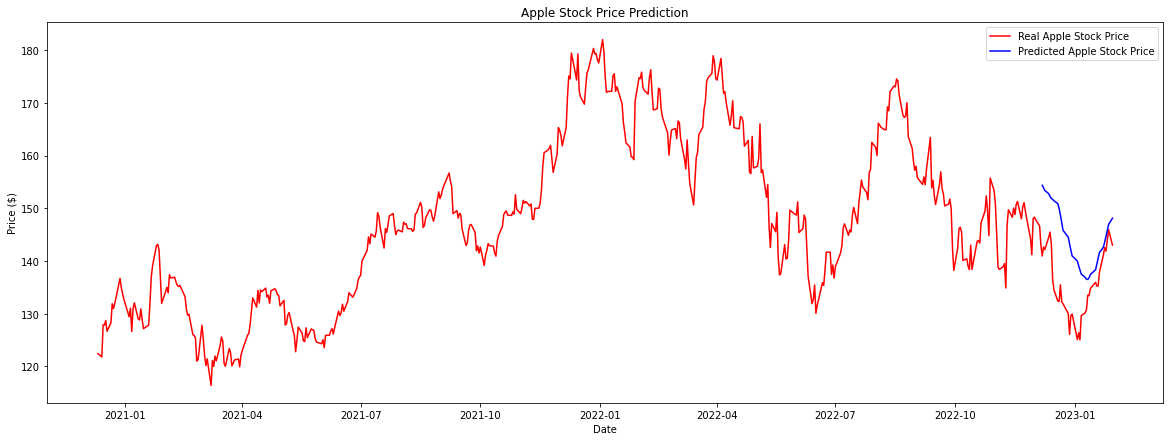

In [51]:
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values[2000:], df_volume[2000:], color = 'red', label = 'Real Apple Stock Price')
plt.plot(df['Date'][-predict.shape[0]:].values, predict, color = 'blue', label = 'Predicted Apple Stock Price')
#plt.xticks(np.arange(100,df[2500:].shape[0],200))
plt.title('Apple Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

# 20-day prediction

In [52]:
pred_ = predict[-1].copy()
prediction_full = []
lookback = 60
df_copy = df.iloc[:, 1:2][1:].values

for j in range(20):
    df_ = np.vstack((df_copy, pred_))
    train_ = df_[:num_rows]
    test_ = df_[num_rows:]
    
    df_volume_ = np.vstack((train_, test_))

    inputs_ = df_volume_[df_volume_.shape[0] - test_.shape[0] - lookback:]
    inputs_ = inputs_.reshape(-1,1)
    inputs_ = sc.transform(inputs_)

    X_test_2 = []

    for k in range(lookback, num_2):
        X_test_3 = np.reshape(inputs_[k-lookback:k, 0], (lookback, 1))
        X_test_2.append(X_test_3)

    X_test_ = np.stack(X_test_2)
    predict_ = model.predict(X_test_)
    pred_ = sc.inverse_transform(predict_)
    prediction_full.append(pred_[-1][0])
    df_copy = df_[j:]

2/2 [==============================] - 0s 25ms/step


In [53]:
prediction_full_new = np.vstack((predict, np.array(prediction_full).reshape(-1,1)))

In [54]:
df_date = df[['Date']]

for h in range(20):
    df_date_add = pd.to_datetime(df_date['Date'].iloc[-1]) + pd.DateOffset(days=1)
    df_date_add = pd.DataFrame([df_date_add.strftime("%Y-%m-%d")], columns=['Date'])
    df_date = df_date.append(df_date_add)
df_date = df_date.reset_index(drop=True)

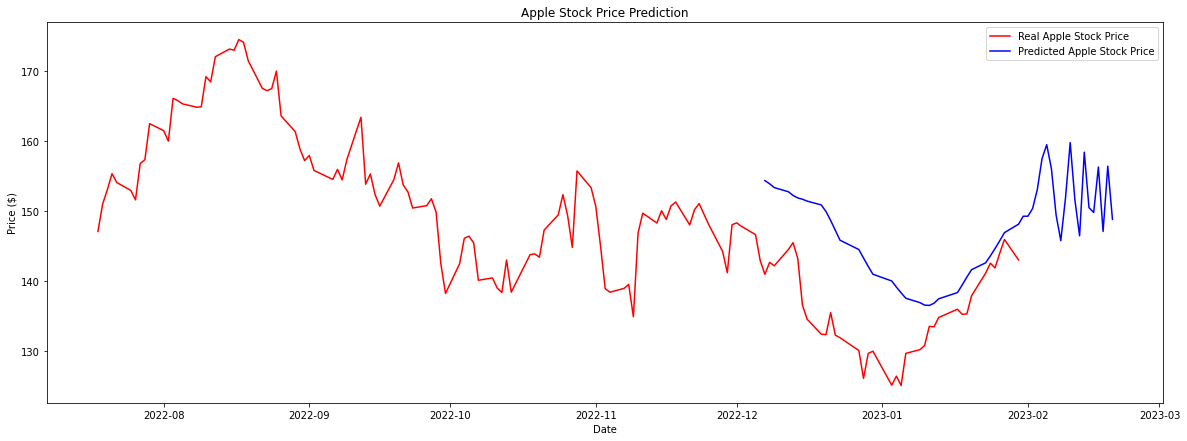

In [55]:
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values[2400:], df_volume[2400:], color = 'red', label = 'Real Apple Stock Price')
plt.plot(df_date['Date'][-prediction_full_new.shape[0]:].values, prediction_full_new, color = 'blue', label = 'Predicted Apple Stock Price')
#plt.xticks(np.arange(100,df[2400:].shape[0],200))
plt.title('Apple Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()